# Load in a checkpoint

In [10]:
from transformers import pipeline

checkpoint = "openai/clip-vit-large-patch14"
detector = pipeline(model=checkpoint, task="zero-shot-image-classification")

Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


# Load in a data set

In [11]:
from datasets import load_dataset

humans = load_dataset("jlbaker361/flickr_humans_0.5k", split="train[:500]")

In [12]:
humans = humans.train_test_split(test_size=0.2) # type: ignore

# Create candidate labels. Note that the labels are evenly distributed by percentage.

In [13]:
# candidate_labels = range(1,100)
# candidate_labels = range(0,70, 5)
# candidate_labels = [f'This is a photo of a human of age {label} years.' for label in candidate_labels]

candidate_labels = ['under 25', 'above 25']
candidate_labels = [f'This is a photo of a human who is {label} years old.' for label in candidate_labels]

# Manual zero-shot image classification

In [14]:
from transformers import AutoProcessor, AutoModelForZeroShotImageClassification
import torch

model = AutoModelForZeroShotImageClassification.from_pretrained(checkpoint), 
processor = AutoProcessor.from_pretrained(checkpoint)

def manual_zero_shot_image_classification(image):
    inputs = processor(images=image, text=candidate_labels, return_tensors="pt", padding=True)
    with torch.no_grad():
        outputs = model(**inputs) # type: ignore
    logits = outputs.logits_per_image[0]
    probs = logits.softmax(dim=-1).numpy()
    scores = probs.tolist()
    image_result = [
        {"score": score, "label": candidate_label}
        for score, candidate_label, in sorted(zip(scores, candidate_labels), key=lambda x: -x[0])
    ]
    return image_result



# Automatic zero-shot image classification

In [15]:
def automatic_zero_shot_image_classification(image):
    return detector(image, candidate_labels=candidate_labels)
    

# Take what we learned and apply across all images

In [16]:
images = [humans['train'][i]['image'] for i in range(0, len(humans["train"]))]

In [17]:
automatic_results = []

for image in images:
    automatic_image_result = automatic_zero_shot_image_classification(image)
    automatic_results.append(automatic_image_result)


In [18]:
# manual_results = []

# for image in images:
#     manual_image_result = manual_zero_shot_image_classification(image)
#     manual_results.append(manual_image_result)


In [19]:
# manual_results

In [20]:
automatic_results

[[{'score': 0.5650479197502136,
   'label': 'This is a photo of a human who is under 25 years old.'},
  {'score': 0.4349519908428192,
   'label': 'This is a photo of a human who is above 25 years old.'}],
 [{'score': 0.7884312868118286,
   'label': 'This is a photo of a human who is under 25 years old.'},
  {'score': 0.2115686982870102,
   'label': 'This is a photo of a human who is above 25 years old.'}],
 [{'score': 0.5440726280212402,
   'label': 'This is a photo of a human who is above 25 years old.'},
  {'score': 0.45592737197875977,
   'label': 'This is a photo of a human who is under 25 years old.'}],
 [{'score': 0.8660041689872742,
   'label': 'This is a photo of a human who is above 25 years old.'},
  {'score': 0.13399581611156464,
   'label': 'This is a photo of a human who is under 25 years old.'}],
 [{'score': 0.6406621932983398,
   'label': 'This is a photo of a human who is above 25 years old.'},
  {'score': 0.35933777689933777,
   'label': 'This is a photo of a human who

# See if the prediction makes sense

In [23]:
def get_score_label_image(results, images, index):
    result = results[index]
    result = result[0] if result[0]["score"] > result[1]["score"] else result[1]
    image = images[index]
    return {"score": result["score"], "label": result["label"], "image": image}

In [28]:
example = get_score_label_image(automatic_results, images, 1)

In [29]:
example["score"]

0.7884312868118286

In [30]:
example["label"]

'This is a photo of a human who is under 25 years old.'

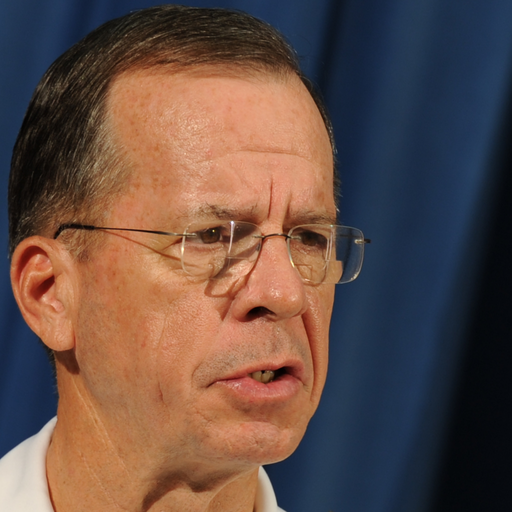

In [31]:
example["image"]